In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
! pip install mne

In [1]:
import pandas as pd
from glob import glob
import numpy as np
import os
import mne
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.cloud import storage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import time


## Functions to read data and load it

In [2]:


def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

In [3]:
def loading_one_subject(subject_number):
    y_raw= []
    raw = []
    fnames =  sorted(glob('/content/drive/MyDrive/train/subj%d_series*_data.csv' % (subject_number)))
    for fname in fnames:
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
    X = pd.concat(raw).reset_index()
    X.drop(columns="index", inplace=True)
    y = pd.concat(y_raw).reset_index()
    y.drop(columns="index", inplace=True)
    return X, y

In [4]:
X, y = loading_one_subject(1) 

In [5]:
X.shape, y.shape


((1422392, 32), (1422392, 6))

In [6]:
type(X),type(y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Function for mean absolute deviation of a signal and wavelet_denoising

In [7]:
def convert_df_to_numpy(df):
    return np.asarray(df.astype(float))
  

In [8]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [9]:
def wavelet_denoising(X, wavelet='db2', level=3):
    coeff = pywt.wavedec(X, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(X)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

In [10]:
def preprocess_data(X, y):
    X= convert_df_to_numpy(X)
    y=convert_df_to_numpy(y)
    X=wavelet_denoising(X)
    return X, y

In [11]:
X, y = preprocess_data(X,y)

In [12]:
X.shape, y.shape

((1422392, 32), (1422392, 6))

In [13]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

## Visualizing a signal before and after wavelet denoising

In [16]:
#signal=pd.read_csv('../raw_date/train/subj1_series1_data.csv')
#signal = signal.drop("id", axis=1)
#filtered = wavelet_denoising(signal, wavelet='db2', level=3)

#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(8,5))
#ax.plot(signal.iloc[:10000,1], label='signal', color="b", alpha=0.5,)
#ax.plot(filtered[:10000,1], label='reconstructed signal',color="k")
#ax.legend(loc='upper left')
#ax.set_title('Denoising with DWT')
#plt.show()

## Test splitting data

In [14]:
def custom_train_test_split(X, y):
     
    splitrate=-X.shape[0]//5*2
    xval=X[splitrate:splitrate//2]
    yval=y[splitrate:splitrate//2]
    xtest=X[splitrate//2:]
    ytest=y[splitrate//2:]
    xtrain=X[:splitrate]
    ytrain=y[:splitrate]
    
    return xtrain, xval, xtest, ytrain, yval, ytest 

In [15]:
# splitting the data 
xtrain, xval, xtest, ytrain, yval, ytest = custom_train_test_split(X, y)

In [16]:
xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape

((853434, 32),
 (284479, 32),
 (284479, 32),
 (853434, 6),
 (284479, 6),
 (284479, 6))

In [17]:
type(xtrain), type(xval), type(xtest), type(ytrain), type(yval), type(ytest)

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

## Scaling data

In [18]:
scaler= StandardScaler()
def data_scaler_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_scaler_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [19]:
X_train_scaled= data_scaler_train(xtrain)
X_val_scaled= data_scaler_test(xval)

In [20]:
X_train_scaled.shape, X_val_scaled.shape

((853434, 32), (284479, 32))

In [21]:
type(X_train_scaled), type(X_val_scaled)

(numpy.ndarray, numpy.ndarray)

## Generators

In [22]:
time_steps = 1000
subsample = 50

In [23]:
def generator(batch_size, xtrain, ytrain):
    while 1:
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1],  x_time_data.shape[2],1)), yy

In [24]:
def valgenerator(xval, yval):
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2],1)), yy

# CNN Model 

In [27]:
load = 1

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu", input_shape = ((time_steps//subsample), 32, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(6, activation = "sigmoid"))


adam = Adam(lr = 0.0001)

model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['accuracy','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 32, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 32, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0

In [28]:
es= EarlyStopping(patience=2)
history =model.fit_generator(generator(32,X_train_scaled, ytrain), steps_per_epoch = 600, epochs = 50,validation_data=valgenerator(X_val_scaled, yval),
                              validation_steps=200,callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
600/600 [==============================] - 8s 9ms/step - loss: 0.6858 - accuracy: 0.1841 - mse: 0.2449 - val_loss: 0.5490 - val_accuracy: 0.1503 - val_mse: 0.1797
Epoch 2/50
600/600 [==============================] - 5s 9ms/step - loss: 0.5500 - accuracy: 0.1865 - mse: 0.1799 - val_loss: 0.4160 - val_accuracy: 0.1331 - val_mse: 0.1176
Epoch 3/50
600/600 [==============================] - 5s 9ms/step - loss: 0.3787 - accuracy: 0.1599 - mse: 0.1022 - val_loss: 0.2522 - val_accuracy: 0.1486 - val_mse: 0.0541
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 0.2350 - accuracy: 0.1843 - mse: 0.0493 - val_loss: 0.1493 - val_accuracy: 0.1648 - val_mse: 0.0262
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1532 - accuracy: 0.2298 - mse: 0.0282 - val_loss: 0.1119 - val_accuracy: 0.2125 - val_mse: 0.0195
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1137 - accuracy: 0.2668 - mse: 0.0218 - val_loss: 0.09

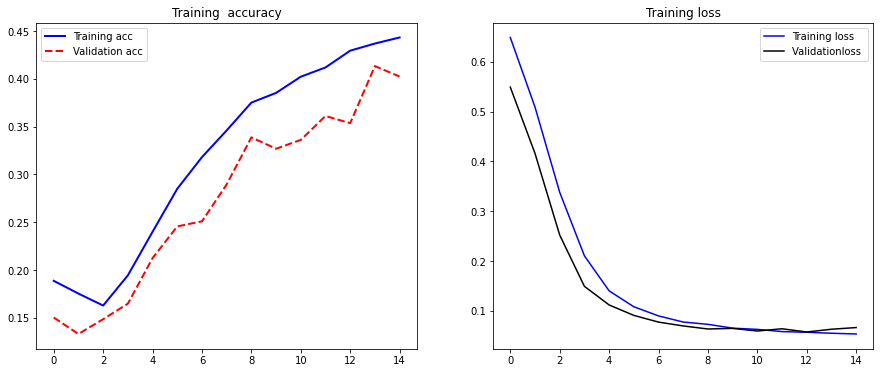

In [29]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'k', label='Validationloss ')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)




In [31]:
# TESTING with Unseen Data

In [38]:
def test_generator(xtest, ytest):
    while 1:
        batch_size = 32
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
            yy.append(ytest[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1)), yy

In [39]:
X_test_scaled = data_scaler_test(xtest)

In [40]:

X_test_scaled.shape

(284479, 32)

In [41]:
gen_data = test_generator(X_test_scaled, ytest)

In [52]:

def scores(gen_data, num_test):
  #scores = []
  predictions=[]
  x_test_=[]
  y_test_=[]
  num_test = num_test
  for i in range(num_test):
      x_test, y_test = next(gen_data)
      while not 1 in y_test:
          x_test, y_test = next(gen_data)
      #score = model.evaluate(x_test, y_test, verbose=0)
      predicts= model.predict(x_test)
      predictions.append(predicts)
      #scores.append(score[1])
      x_test_.append(x_test)
      y_test_.append(y_test)
  #scores = np.asarray(scores)
  #np.mean(scores),
  return  x_test_, y_test_ , predictions
  

In [68]:
x_test_, y_test_, predictions = scores(gen_data, 5000)

In [69]:
np.shape(np.round(predictions))

(5000, 32, 6)

In [72]:
np.round(predictions).flatten().reshape(160000,6)


array([[0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [71]:
np.asarray(y_test_).flatten().reshape(160000,6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [70]:
 l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
print(classification_report(np.asarray(y_test_).flatten().reshape(160000,6), np.round(predictions).flatten().reshape(160000,6), target_names=l))

                precision    recall  f1-score   support

Handstart (HS)       0.39      0.03      0.06      6074
 Grasping (GS)       0.67      0.27      0.38      6273
     Lift (LT)       0.67      0.24      0.36      6242
     Hold (HD)       0.50      0.11      0.19      6300
  Replace (RP)       0.61      0.29      0.40      6292
  Release (RL)       0.58      0.24      0.34      6300

     micro avg       0.60      0.20      0.30     37481
     macro avg       0.57      0.20      0.28     37481
  weighted avg       0.57      0.20      0.29     37481
   samples avg       0.03      0.03      0.03     37481



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
def tester_generator(xtest, time_steps= 1000, subsample=50):
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, 32))
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
        yield x_time_data.reshape((x_time_data.shape[0],x_time_data.shape[1], x_time_data.shape[2], 1))

In [85]:
gen_data2 = tester_generator(X_test_scaled)

Predic

In [137]:
def prediction_test(df, num_test):
  predictions = []
  num_test = num_test
  for i in range(num_test):
      x_test= next(df)
      predict = model.predict(x_test)
      predictions.append(predict)
  l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
  results=[]
  for elem in np.round(predictions):
    if elem[0][0] == 1:
       results.append(l[0])
    if elem[0][1] ==1:
      results.append(l[1])
    if elem[0][2] ==1:
      results.append(l[2])
    if elem[0][3] ==1:
      results.append(l[3])
    if elem[0][4] ==1:
      results.append(l[4])
    if elem[0][5] ==1:
      results.append(l[5])
  return np.reshape(results,(num_test,6))

In [123]:
#preds = [[[0., 1., 0., 0., 0., 0.]],
        [[0., 0., 0., 0., 0., 0.]],
        [[0., 0., 0., 0., 1., 0.]],
        [[0., 1., 0., 0., 0., 0.]],
        [[0., 0., 0., 1., 1., 0.]],
        [[0., 0., 0., 0., 0., 0.]],
        [[0., 0., 0., 0., 0., 0.]],
        [[1., 1., 1., 1., 1., 1.]],
        [[0., 0., 0., 0., 1., 0.]],
        [[0., 0., 0., 1., 0., 0.]]]

In [ ]:
def prediction_labels(pred_list):
    predicted_labels = []
    labels = {0 : 'Handstart (HS)',
                   1 : "Grasping (GS)",
                   2 : "Lift (LT)",
                   3 : "Hold (HD)",
                   4 : "Replace (RP)",
                   5 : "Release (RL)"}
    for pred in pred_list:

        list_to_np = np.array(pred[0])
        pos_indices = np.where(list_to_np == 1)[0]
        if len(pos_indices) ==0:
            predicted_labels.append('No Movement')
        else:
            list_labeled_mov = []
            for index in pos_indices:
                list_labeled_mov.append(labels[index])
            predicted_labels.append(list_labeled_mov)
    return predicted_labels
prediction_labels(preds)